# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [28]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

In [29]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper

    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [45]:
def compute_average_enrichment(pkl_path, model):
    
    enrich_1_list = [] 
    enrich_10_list = []
    
#     import pdb
#     pdb.set_trace()
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
#         for seed in data.keys():

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):
#             print(seed)

            if isinstance(data[seed]["y_true"], np.ndarray):
                y_true = data[seed]["y_true"]
            else:
                y_true = np.concatenate(data[seed]["y_true"]) 
            y_pred = np.array(data[seed]["y_pred"])

    
            eta = np.array(data[seed]["eta"])

            if np.unique(y_true).shape[0] < 2 :
                metric = 0
            else:
                metric = recall_score(y_pred=y_pred, y_true=y_true)
                if model in ["rf", "mlp"]:
                    eta= eta[:, 1]

            enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
            enrich_1_list.append(enrich_1)
                
            enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
            enrich_10_list.append(enrich_10)
            
    
    return np.mean(enrich_1_list), np.std(enrich_1_list), np.mean(enrich_10_list), np.std(enrich_10_list)




def compute_average_train_time(pkl_path):
    print(pkl_path)
    train_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        target = pkl_path.name.split(".")[2]
        split = pkl_path.name.split(".")[1]
        model = pkl_path.name.split(".")[3]

        range_limit = 10
    
        if "openhd" in model:
            range_limit=1
        for seed in range(range_limit):

            train_time  = data[seed]["train_time"]

            if "openhd" in model:
                pass
            
            elif "mlp" in model:
                train_time = train_time / 10 # trained MLP for max 10 epochs...check that it hits that but assume it didn't converge that quickly
            elif "rf" in model:
                train_time = train_time # there's no concept of epoch in a random forest
            else:
                train_time = train_time/10 # this should catch all HD models which were trained for 10 epochs per seed
            
            train_time_list.append(train_time)
            
            
    
    return np.mean(train_time_list)



def compute_average_inference_time(pkl_path):
    
    test_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        

        range_limit = 10
    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):

            test_time  = data[seed]["test_time"]

            test_time_list.append(test_time)
            
            
    
    return np.mean(test_time_list)
                    

In [46]:
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4")
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/0")
# data_p = Path("/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results")

In [47]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    print(pkl_path)
    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# LIT-PCBA Results

In [48]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [49]:
color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[2],
    "smiles-pe.bpe.0": rocket_color_pal[4],   
#     "smiles-pe.ngram.1": color_pal[0],
#     "selfies.None": "purple",
"selfies.atomwise": green_color_pal[4],
#     "selfies.selfies-charwise": color_pal[2],
    "ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
#     "openhd": "green",
    "mlp": blue_color_pal[7],
#     "Vina": color_pal[2]
}



marker_dict = {
#     "smiles-pe": "+",
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
#     "smiles-pe.ngram.1": "+",
    "selfies.atomwise": "*",
#     "selfies.selfies-charwise": "*",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
#     "openhd": "*",
    "mlp": "+",
#     "Vina": "+"
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
    ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
    ("ecfp", "HDBind-ECFP"),
    ("rp", "HDBind-ECFP+RP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
#     ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
    "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
    "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
    "ecfp": "HDBind-ECFP",
    "rp": "HDBind-RPFP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
}


linestyle_dict = {
    "smiles-pe.atomwise.0": "-", 
    "smiles-pe.bpe.0": ":",
    "selfies.None": "-",
    "ecfp": ":",
    "rp": "-.",
    "rf": "-",
    "mlp": ":",
    "Vina": "-"
}

In [65]:
def aggregate_results(dataset):
    
    
    
    
    model_metric_dict = {"model": [], "enrich-1-mean": [], 
                         "enrich-1-std":[], "enrich-10-mean": [], 
                         "enrich-10-std": [], "train_time":[], "test_time": []}
    

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]

    for model, color in color_dict.items():
                        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        
        
        data_path_list = list(data_p.glob(f"{dataset}*.{model}*pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []

        
        for path in tqdm(data_path_list, total=len(data_path_list)):
            
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
                
                
            enrich_1_mean, enrich_1_std, enrich_10_mean, enrich_10_std = compute_average_enrichment(path, model=model)
            train_time_mean = compute_average_train_time(path)
            test_time_mean = compute_average_inference_time(path)
            
            
            model_metric_dict["model"].append(model)
            model_metric_dict["enrich-1-mean"].append(enrich_1_mean)
            model_metric_dict["enrich-1-std"].append(enrich_1_std)
            model_metric_dict["enrich-10-mean"].append(enrich_10_mean)
            model_metric_dict["enrich-10-std"].append(enrich_10_std)
            model_metric_dict["train_time"].append(train_time_mean)
            model_metric_dict["test_time"].append(test_time_mean)

    return enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.smiles-pe.atomwise.0.pkl


  7%|▋         | 1/15 [00:15<03:35, 15.39s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.smiles-pe.atomwise.0.pkl


 13%|█▎        | 2/15 [00:35<03:59, 18.42s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.smiles-pe.atomwise.0.pkl


 27%|██▋       | 4/15 [00:45<01:40,  9.14s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.smiles-pe.atomwise.0.pkl


 33%|███▎      | 5/15 [00:46<00:59,  5.91s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.smiles-pe.atomwise.0.pkl


 40%|████      | 6/15 [00:46<00:35,  3.97s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.smiles-pe.atomwise.0.pkl


 60%|██████    | 9/15 [01:01<00:21,  3.61s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.smiles-pe.atomwise.0.pkl


 67%|██████▋   | 10/15 [01:22<00:45,  9.07s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.smiles-pe.atomwise.0.pkl


 80%|████████  | 12/15 [01:39<00:24,  8.18s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.smiles-pe.atomwise.0.pkl


 87%|████████▋ | 13/15 [01:58<00:22, 11.33s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.smiles-pe.atomwise.0.pkl


 93%|█████████▎| 14/15 [02:21<00:14, 14.80s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.smiles-pe.atomwise.0.pkl


  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.smiles-pe.bpe.0.pkl


  7%|▋         | 1/15 [00:18<04:21, 18.69s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.smiles-pe.bpe.0.pkl


 13%|█▎        | 2/15 [00:36<03:58, 18.38s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.smiles-pe.bpe.0.pkl


 20%|██        | 3/15 [00:58<03:59, 19.98s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.smiles-pe.bpe.0.pkl


 33%|███▎      | 5/15 [01:20<02:12, 13.20s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.smiles-pe.bpe.0.pkl


 40%|████      | 6/15 [01:34<02:01, 13.54s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.smiles-pe.bpe.0.pkl


 53%|█████▎    | 8/15 [01:55<01:16, 10.89s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.smiles-pe.bpe.0.pkl


 60%|██████    | 9/15 [01:56<00:47,  7.94s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.smiles-pe.bpe.0.pkl


 73%|███████▎  | 11/15 [02:14<00:31,  7.86s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.smiles-pe.bpe.0.pkl


 80%|████████  | 12/15 [02:14<00:16,  5.53s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.smiles-pe.bpe.0.pkl


 93%|█████████▎| 14/15 [02:36<00:07,  7.33s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.smiles-pe.bpe.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.smiles-pe.bpe.0.pkl


  7%|▋         | 1/15 [00:00<00:02,  4.71it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.selfies.atomwise.0.pkl


 13%|█▎        | 2/15 [00:18<02:22, 10.99s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.selfies.atomwise.0.pkl


 27%|██▋       | 4/15 [00:42<01:54, 10.42s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.selfies.atomwise.0.pkl


 33%|███▎      | 5/15 [01:04<02:26, 14.60s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.selfies.atomwise.0.pkl


 47%|████▋     | 7/15 [01:22<01:26, 10.86s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.selfies.atomwise.0.pkl


 67%|██████▋   | 10/15 [01:41<00:31,  6.37s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.selfies.atomwise.0.pkl


 73%|███████▎  | 11/15 [01:41<00:17,  4.47s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.selfies.atomwise.0.pkl


 80%|████████  | 12/15 [02:03<00:29,  9.79s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.selfies.atomwise.0.pkl


 87%|████████▋ | 13/15 [02:10<00:18,  9.16s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.selfies.atomwise.0.pkl


 93%|█████████▎| 14/15 [02:32<00:12, 12.81s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.selfies.atomwise.0.pkl


  7%|▋         | 1/15 [00:03<00:42,  3.06s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.ecfp.atomwise.0.pkl


 20%|██        | 3/15 [00:17<01:03,  5.27s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.ecfp.atomwise.0.pkl


 33%|███▎      | 5/15 [00:40<01:20,  8.04s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.ecfp.atomwise.0.pkl


 47%|████▋     | 7/15 [00:48<00:43,  5.44s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.ecfp.atomwise.0.pkl


 53%|█████▎    | 8/15 [01:09<01:13, 10.45s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.ecfp.atomwise.0.pkl


 67%|██████▋   | 10/15 [01:28<00:45,  9.06s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.ecfp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.ecfp.atomwise.0.pkl


 73%|███████▎  | 11/15 [01:45<00:45, 11.39s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.ecfp.atomwise.0.pkl


 80%|████████  | 12/15 [02:00<00:37, 12.58s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.ecfp.atomwise.0.pkl


 87%|████████▋ | 13/15 [02:19<00:28, 14.41s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.ecfp.atomwise.0.pkl


100%|██████████| 15/15 [02:32<00:00, 10.19s/it]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.ecfp.atomwise.0.pkl


  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.rp.atomwise.0.pkl


  7%|▋         | 1/15 [00:16<03:52, 16.63s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.rp.atomwise.0.pkl


 13%|█▎        | 2/15 [00:31<03:26, 15.85s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.rp.atomwise.0.pkl


 20%|██        | 3/15 [00:50<03:24, 17.01s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.rp.atomwise.0.pkl


 27%|██▋       | 4/15 [01:09<03:18, 18.04s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.rp.atomwise.0.pkl


 40%|████      | 6/15 [01:29<01:50, 12.23s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.rp.atomwise.0.pkl


 53%|█████▎    | 8/15 [01:49<01:11, 10.20s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.rp.atomwise.0.pkl


 60%|██████    | 9/15 [01:49<00:42,  7.06s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.rp.atomwise.0.pkl


 67%|██████▋   | 10/15 [01:52<00:28,  5.70s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.rp.atomwise.0.pkl


 73%|███████▎  | 11/15 [02:05<00:32,  8.15s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.rp.atomwise.0.pkl


 87%|████████▋ | 13/15 [02:12<00:10,  5.46s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.rp.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.rp.atomwise.0.pkl


 93%|█████████▎| 14/15 [02:13<00:03,  3.87s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.rp.atomwise.0.pkl


  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.rf.None.0.pkl


  7%|▋         | 1/15 [00:03<00:43,  3.09s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.rf.None.0.pkl


 20%|██        | 3/15 [00:04<00:15,  1.29s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.rf.None.0.pkl


 27%|██▋       | 4/15 [00:08<00:23,  2.09s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.rf.None.0.pkl


 33%|███▎      | 5/15 [00:10<00:21,  2.18s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.rf.None.0.pkl


 53%|█████▎    | 8/15 [00:14<00:11,  1.63s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.rf.None.0.pkl


 67%|██████▋   | 10/15 [00:16<00:06,  1.30s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.rf.None.0.pkl


 73%|███████▎  | 11/15 [00:20<00:07,  1.97s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.rf.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.rf.None.0.pkl


 87%|████████▋ | 13/15 [00:23<00:03,  1.78s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.rf.None.0.pkl


100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.rf.None.0.pkl


  0%|          | 0/15 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.TP53.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.GBA.mlp.None.0.pkl


 13%|█▎        | 2/15 [00:02<00:19,  1.49s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.IDH1.mlp.None.0.pkl


 20%|██        | 3/15 [00:06<00:29,  2.44s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ALDH1.mlp.None.0.pkl


 27%|██▋       | 4/15 [00:08<00:22,  2.01s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ADRB2.mlp.None.0.pkl


 40%|████      | 6/15 [00:11<00:15,  1.67s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MTORC1.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.FEN1.mlp.None.0.pkl


 47%|████▋     | 7/15 [00:14<00:18,  2.30s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PKM2.mlp.None.0.pkl


 67%|██████▋   | 10/15 [00:17<00:06,  1.25s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ago.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.PPARG.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.VDR.mlp.None.0.pkl


 73%|███████▎  | 11/15 [00:21<00:07,  1.85s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.KAT2A.mlp.None.0.pkl


 80%|████████  | 12/15 [00:24<00:06,  2.29s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.ESR1_ant.mlp.None.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.OPRK1.mlp.None.0.pkl


100%|██████████| 15/15 [00:27<00:00,  1.85s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4/lit_pcba.MAPK1.mlp.None.0.pkl


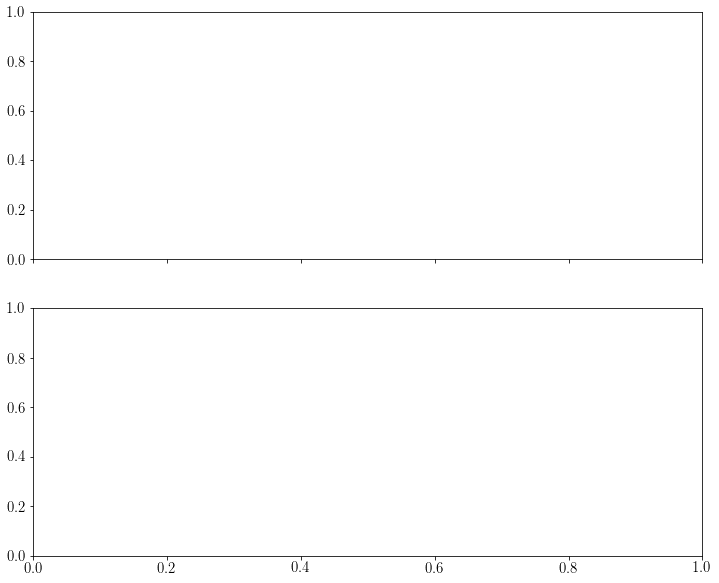

In [66]:
lit_pcba_enrich_f, lit_pcba_enrich_1_ax, lit_pcba_enrich_10_ax, model_metric_dict = aggregate_results(dataset="lit_pcba")


In [67]:
print([len(x) for x in model_metric_dict.values()])
print([x for x in model_metric_dict.keys()])

[105, 105, 105, 105, 105, 105, 105]
['model', 'enrich-1-mean', 'enrich-1-std', 'enrich-10-mean', 'enrich-10-std', 'train_time', 'test_time']


In [71]:
model_metric_dict

{'model': ['smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.atomwise.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'smiles-pe.bpe.0',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',
  'selfies.atomwise',


In [72]:
# 'smiles-pe.ngram.2', 'smiles-pe.ngram.3', 'rf', 'mlp'

In [74]:
# import pdb 
# pdb.set_trace()

model_metric_df = pd.DataFrame(model_metric_dict)
# model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
#                                       "enrich-1": [tup[1] for tup in model_metric_df[col].values],
#                                       "enrich-10": [tup[2] for tup in model_metric_df[col].values],
#                                       "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

# model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

,model,enrich-1-mean,enrich-1-std,enrich-10-mean,enrich-10-std,train_time,test_time
0,smiles-pe.atomwise.0,2.379506,4.440892e-16,0.690430,7.142375e-02,38.848914,13.895157
1,smiles-pe.atomwise.0,0.000000,0.000000e+00,0.999912,1.110223e-16,46.540521,16.924386
2,smiles-pe.atomwise.0,3.145934,1.177505e+00,1.732414,4.218971e-01,26.066654,9.235091
3,smiles-pe.atomwise.0,0.905351,1.010145e+00,0.869853,4.423718e-01,7.906326,2.984322
4,smiles-pe.atomwise.0,12.030612,4.010204e+00,4.571429,2.099563e+00,0.738877,0.468956
...,...,...,...,...,...,...,...
100,mlp,32.884113,3.521469e+00,6.094886,1.619469e-01,12.208571,0.970568
101,mlp,19.384642,2.921535e+00,3.510043,3.957108e-01,18.010445,2.853678
102,mlp,22.793787,6.980706e+00,4.322199,6.411792e-01,0.596575,0.033667
103,mlp,39.976296,1.332543e+01,6.333333,1.452966e+00,11.730690,1.898424


In [75]:
# model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
# model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

In [76]:
# sns.boxplot(data=model_metric_df, x="model", y="metric", ax=lit_pcba_ax[0], palette=color_dict)
# lit_pcba_f

In [82]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1-mean", ax=lit_pcba_enrich_1_ax, palette=color_dict)
lit_pcba_enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
lit_pcba_enrich_1_ax.set_xlabel("")
lit_pcba_enrich_1_ax.set_ylabel("")
lit_pcba_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

# lit_pcba_enrich_1_ax.set_xticklabels(labels)
# labels = [x[1] for x in model_order_list]
# labels = [model_name_dict[x.get_text()] for x in lit_pcba_enrich_1_ax.get_xticklabels()]
# lit_pcba_enrich_1_ax.set_xticklabels(labels)
lit_pcba_enrich_1_ax.set_ylabel("EF")




plt.tight_layout()
# lit_pcba_enrich_1_f.savefig("lit_pcba_enrich_1.png", dpi=600, bbox_inches="tight")
# lit_pcba_enrich_1_f

<Figure size 432x288 with 0 Axes>

In [83]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10-mean", ax=lit_pcba_enrich_10_ax, palette=color_dict)
lit_pcba_enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
lit_pcba_enrich_10_ax.set_xlabel("")
lit_pcba_enrich_10_ax.set_ylabel("")
lit_pcba_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
labels = [item.get_text() for item in lit_pcba_enrich_10_ax.get_xticklabels()]
labels = [model_name_dict[x.get_text()] for x in lit_pcba_enrich_10_ax.get_xticklabels()]
lit_pcba_enrich_10_ax.set_xticklabels(labels)
lit_pcba_enrich_10_ax.set_ylabel("EF")
plt.tight_layout()
# lit_pcba_enrich_10_f.savefig("lit_pcba_enrich_10.png", dpi=600, bbox_inches="tight")
# lit_pcba_enrich_10_f

<Figure size 432x288 with 0 Axes>

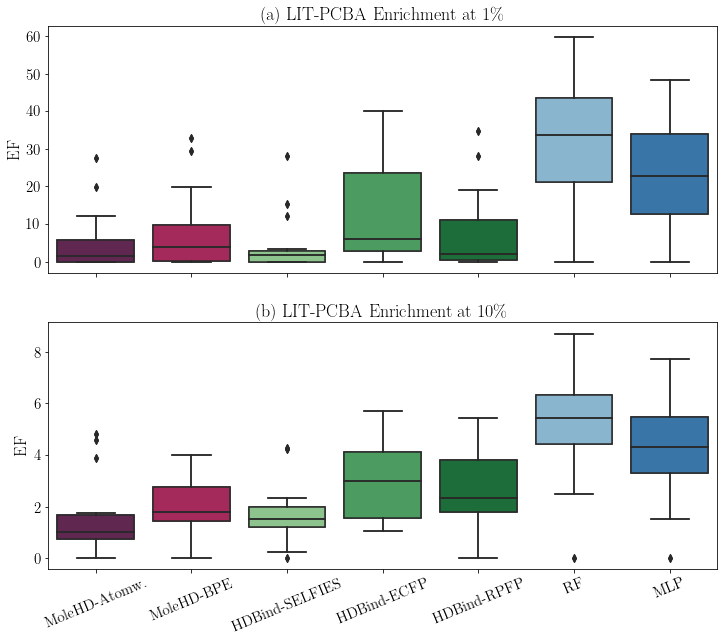

In [84]:
lit_pcba_enrich_f.savefig("lit_pcba_enrich.png", dpi=600, bbox_inches="tight")

lit_pcba_enrich_f


In [86]:
model_metric_df.groupby("model").describe()

enrich-1-mean                                        \
                             count       mean        std  min        25%   
model                                                                      
ecfp                          15.0  14.076196  14.039168  0.0   2.895247   
mlp                           15.0  23.857766  14.031995  0.0  12.564738   
rf                            15.0  32.085894  17.058962  0.0  21.214078   
rp                            15.0   7.955462  11.233038  0.0   0.325878   
selfies.atomwise              15.0   4.574143   7.931471  0.0   0.000000   
smiles-pe.atomwise.0          15.0   5.257589   8.331998  0.0   0.000000   
smiles-pe.bpe.0               15.0   8.169572  10.901077  0.0   0.194004   

                                                      enrich-1-std  \
                            50%        75%        max        count   
model                                                                
ecfp                   6.121466  23.516424  40.102041         15.0   
mlp                   22.793787  34.061602  48.338587         15.0   
rf                    33.630178  43.635317  59.744321         15.0   
rp                     2.040489  11.168654  34.756364         15.0   
selfies.atomwise       1.810702   2.789491  27.998182         15.0   
smiles-pe.atomwise.0   1.628374   5.653944  27.515455         15.0   
smiles-pe.bpe.0        4.009254   9.785020  32.825455         15.0   

                                    ... train_time             test_time  \
                              mean  ...        75%         max     count   
model                               ...                                    
ecfp                  3.860912e+00  ...  42.825877   48.501519      15.0   
mlp                   6.314666e+00  ...  11.969631  101.746651      15.0   
rf                    3.079019e-15  ...   7.065135   13.916319      15.0   
rp                    2.413042e+00  ...  38.654116   45.237528      15.0   
selfies.atomwise      8.926151e-01  ...  41.087197   47.290838      15.0   
smiles-pe.atomwise.0  1.274133e+00  ...  41.983385   60.565444      15.0   
smiles-pe.bpe.0       2.843145e+00  ...  46.425499   63.529019      15.0   

                                                                          \
                           mean       std       min       25%        50%   
model                                                                      
ecfp                   7.876104  6.510600  0.192361  0.963493   9.421970   
mlp                    0.764835  0.883107  0.006982  0.045981   0.430658   
rf                     0.787652  0.682118  0.019508  0.100414   0.838919   
rp                     7.336910  5.963268  0.192000  0.792397   9.537929   
selfies.atomwise       8.875971  7.193154  0.220750  0.979048  11.404157   
smiles-pe.atomwise.0   9.414018  7.701147  0.221521  1.034693  11.723572   
smiles-pe.bpe.0       10.441032  8.603245  0.230170  1.398106  12.163090   

                                            
                            75%        max  
model                                       
ecfp                  13.987301  16.133172  
mlp                    0.976061   2.853678  
rf                     1.192134   2.047640  
rp                    12.747834  14.928642  
selfies.atomwise      15.314161  17.471893  
smiles-pe.atomwise.0  15.474549  22.204742  
smiles-pe.bpe.0       16.990059  23.623640  

[7 rows x 48 columns]

In [88]:
group_dict = {group_name: group_df for group_name, group_df in model_metric_df.groupby('model')}

In [89]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['train_time'].mean()}")

ecfp-23.979008684476216
mlp-13.517712831020358
rf-5.028178724447885
rp-22.270036433060962
selfies.atomwise-23.864359796524045
smiles-pe.atomwise.0-25.628446019331616
smiles-pe.bpe.0-28.20012922493617


In [90]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['test_time'].mean()}")

ecfp-7.87610372543335
mlp-0.764835287729899
rf-0.7876524146397907
rp-7.336910459200542
selfies.atomwise-8.875970926284792
smiles-pe.atomwise.0-9.414018405278522
smiles-pe.bpe.0-10.441032210985819


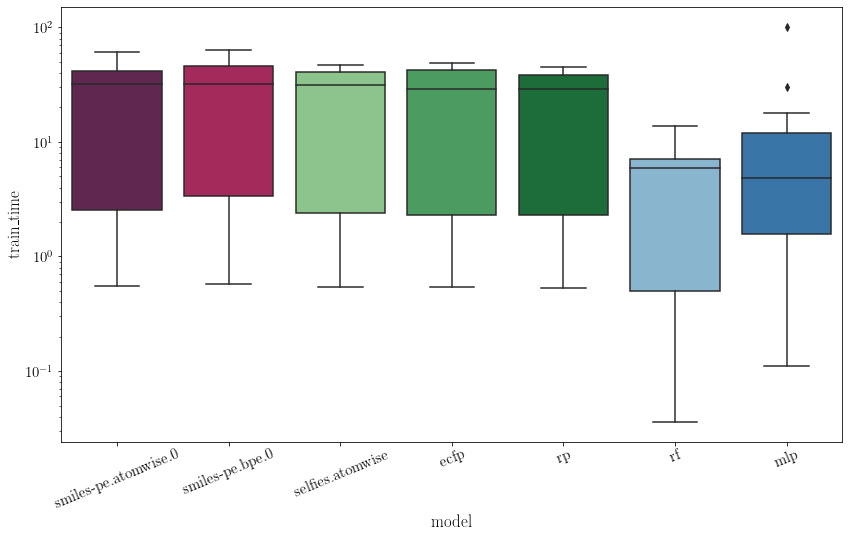

In [93]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="train_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

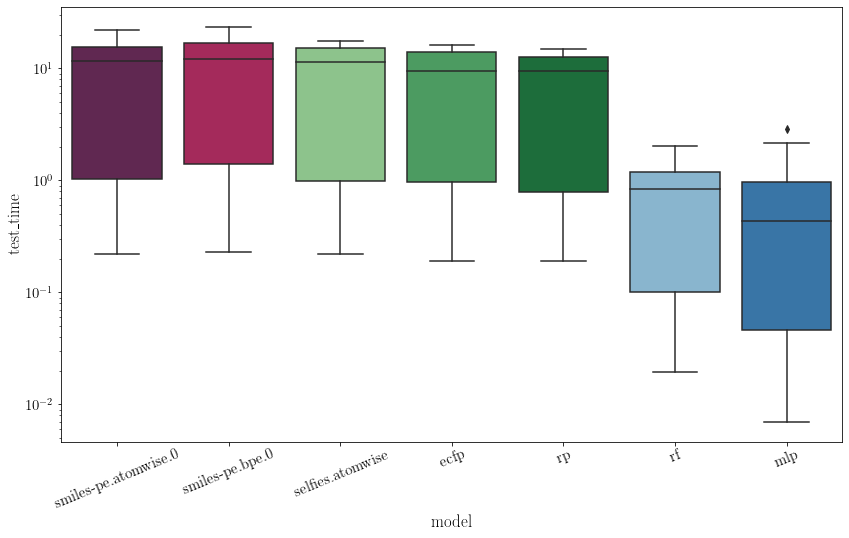

In [94]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="test_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")